# 1. Background

- Tornadoes occur at a high frequency in the United States compared with other natural hazards such as earthquakes and tsunamis but have a substantially smaller footprint. Even a single high-intensity tornado can result in high casualty rates and catastrophic economic losses and social consequences, particularly for small to medium communities.
- The city of Joplin, Missouri, USA, was hit by an EF-5 tornado on May 22, 2011.  The National Institute of Standards and Technology (NIST) conducted a technical investigation of this devastating event which can be found at: https://nvlpubs.nist.gov/nistpubs/NCSTAR/NIST.NCSTAR.3.pdf .  The Center for Risk-Based Community Resilience Planning  simulated this event for buildings and the electrical power network of Joplin in IN-CORE.  This Juypter Notebook provides an example of how to use IN-CORE.
- The initial damage prediction utilized the tornado path, tornado fragility curves representative of a 19- archetype building dataset, and EPN datasets.  Generic tornado paths are also available in IN-CORE, or a user defined tornado path is possible. 
- The functionality of the infrastructure was linked with a computable general equilibrium (CGE) economics model that computes specific community resilience metrics in economic terms.  A population dislocation model provides resilience metrics related to socio-demographics such as population dislocation as a function of income or race/ethnicity.

## Prerequisites

The following modules are necessary to run this notebook. To ensure dependencies are correct, install all modules through **conda**. 

| Module | Version | Notes |
| --- | --- | --- |
| pyIncore | =>1.3.0 | see: https://incore.ncsa.illinois.edu/doc/incore/install_pyincore.html |
| pyIncore_viz | =>1.5.0 | see: https://incore.ncsa.illinois.edu/doc/pyincore_viz/index.html |
| matplotlib | 3.1.2 | used for plotting results |
| contextily | 0.99.0 | used for context geo-tiles |
| descartes | 1.1.0 | used for visualization of geometric objects as matplotlib paths |

Economic Computable General Equilibrium (CGE) Model uses the ipopt solver. The ipopt solver is installed with pyIncore, so the environment should have the solver in it. **If you have a trouble to run CGE model later, please see the instruction at CGE section in this document.**

- Building data: 5dbc8478b9219c06dd242c0d
- Electric power substation data: 5d92355bb9219c06ae7e386a
- Hazard data:   5d07cbeab9219c065b080930
- Building Mapping:       5d8942dfb9219c068ea795ea

## 1.1 Basics of IN-CORE modules

IN-CORE via ```pyincore``` provides a collection of Python classes that wrap the functionality for accessing the IN-CORE web services using Python methods. These classes provide access to Hazards, DFR3 curves, and Data. 

![pyincore-diagram.png](resource/pyincore-diagram.png)

To use IN-CORE in Jupyter Notebooks, we start by importing the modules we need.

* **IncoreClient:** this entity provides access and authentication to IN-CORE services. To access the services, users
  require to have a valid *username* and *password*. Importing ```IncoreClient``` and creating a named instance of the
  client is the first step toward using IN-CORE by establishing a remote connection to various simulation and data
  access services. The variable containing that instance is used by various other services
  to validate the user's identity, as well as provide access to pieces of information required across tasks. *This step
  only needs to be done once.*
* **HazardService:** once the ```IncoreClient``` has been initiated, the ```HazardService``` module uses the information
  from that client to administer existing information about known or new hazards. ```HazardService``` can:
  * Retrieve existing metadata for various hazards
  * Search hazards per specific information
  * Request creation of a new hazard
  * Request deletion of a new hazard

For more information on **pyincore** modules, see the documentation here: https://incore.ncsa.illinois.edu/doc/pyincore/index.html

In [50]:
import pandas as pd
import os
import json
from pathlib import Path
import contextily as ctx
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import random

from pyincore import IncoreClient, DataService, HazardService, Dataset, FragilityService, MappingSet
from pyincore import HHRSOutputProcess
from pyincore.analyses.capitalshocks import CapitalShocks
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.epfdamage import EpfDamage
from pyincore.utils.dataprocessutil import DataProcessUtil
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability 
from pyincore.analyses.joplincge import JoplinCGEModel
from pyincore.analyses.housingrecoverysequential import HousingRecoverySequential
from pyincore.analyses.socialvulnerability import SocialVulnerability
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.utils.dataprocessutil import DataProcessUtil as util
from pyincore.models.fragilitycurveset import FragilityCurveSet

from pyincore_viz.plotutil import PlotUtil as frag_plot
from pyincore_viz.geoutil import GeoUtil as viz

In [51]:
# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

### IN-CORE Client and Services

In [52]:
client = IncoreClient()
data_services = DataService(client)

Connection successful to IN-CORE services. pyIncore version detected: 1.18.1


## 1.2 Hazard, Data, and Fragility
This section introduces the input for the infrastructure damage analysis including the tornado path, building dataset, and building fragility curves for tornado.

### Tornado Path
This figure shows the 2011 Joplin tornado path with EF zones provided in the legend. The tornado path represents the wind speed within the vortex (multi-vortex in the case of Joplin) that was estimated to have EF5 wind speeds of more than 200 mph, reducing to EF4 wind speeds as the areas move outward from the vortex, and eventually reaching EF1 zone. (Attary et al. 2018)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


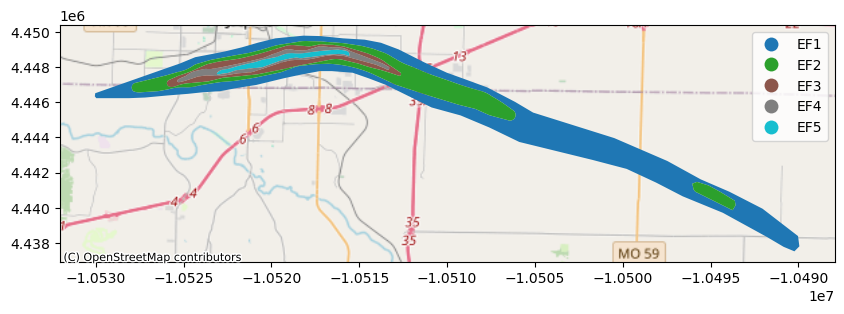

In [53]:
# The simulated EF-5 tornado shows geographical locations and the range
# of wind speed of tornado hazard in Joplin.
hazard_id = "5d07cbeab9219c065b080930"
viz.plot_tornado(hazard_id, client, basemap=True)

### Joplin Buildings

The 19 archetype buildings are used herein to represent the Joplin community. The selected building archetypes consider building characteristics such as footprint area, roof structure, number of stories, and so on. (Attary et al. 2018, Memari et al. 2018)


Joplin building archetypes

| Archetype | Building Type               |
|-------  |-------------------------------|
|   1, 5  | Residential wood building     |
|     6   | Business and retail building  |
|     7   | Light industrial building     |
|     8   | Heavy industrial building     |
|     9   | Elementary/middle school      |
|    10   | High school                   |
|    11   | Fire/police station           |
|    12   | Hospital                      |
|    13   | Community center/church       |
|    14   | Government building           |
|    15   | Large big-box                 |
|    16   | Small big-box                 |
|    17   | Mobile home                   |
|    18   | Shopping center               |
|    19   | Office building               |


Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


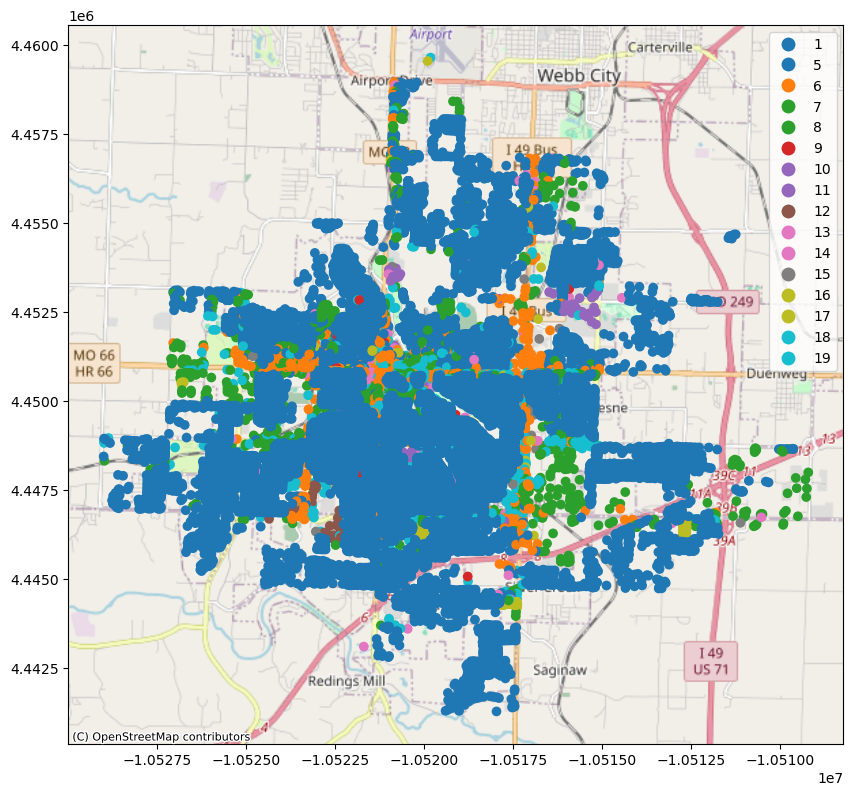

In [54]:
building_dataset_id = "5dbc8478b9219c06dd242c0d"  # Load the Joplin building dataset.
bldg_dataset = Dataset.from_data_service(building_dataset_id, DataService(client))
viz.plot_map(bldg_dataset, column='archetype',category='True')

### Fragility Curves
There 19 fragility curves set for these 19 building types in the four damage states, which covers the entire range of wind speeds associated with tornadoes (Attary et al. 2018, Memari et al. 2018). Below we selected 3 types to plot as examples.

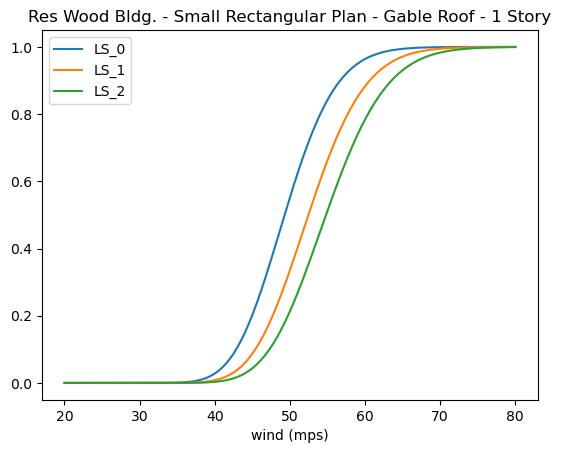

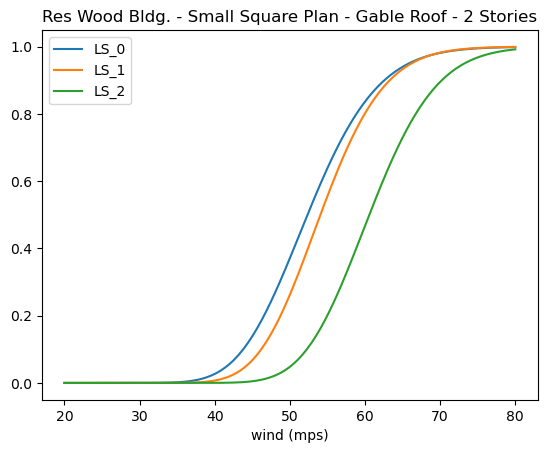

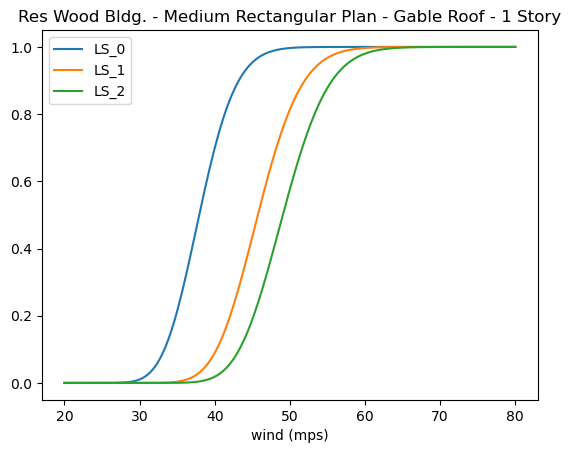

In [55]:
fragility_service = FragilityService(client)
mapping_id = "5d8942dfb9219c068ea795ea"
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

# plot fragility for the first 3 archetypes using pyincore viz method
for mapping in mapping_set.mappings[:3]:
    fragility_id = mapping.entry['Non-Retrofit Fragility ID Code']
    fragility_set = FragilityCurveSet(fragility_service.get_dfr3_set(fragility_id))
    frag_plot.get_fragility_plot(fragility_set, start=20, end=80).show()

# 2. Building Damage Analysis

The models in this section predict community-level building damage:
1. First, a fragility is obtained based on the hazard type and attributes of the building.
2. Based on the fragility, the hazard intensity at the location of the building is computed.
3. Using this information, the probability of exceeding each limit state is computed, along with the probability of damage state. 

**Details can be found: [Building Damge Analysis](https://incore.ncsa.illinois.edu/doc/incore/analyses/building_dmg.html)**

In [56]:
building_dataset_id = "5dbc8478b9219c06dd242c0d"  # Load the Joplin building dataset.
buildings = Dataset.from_data_service(building_dataset_id, data_services)

hazard_id = "5d07cbeab9219c065b080930"
hazard_type = "tornado"

fragility_service = FragilityService(client)
mapping_id = "5d8942dfb9219c068ea795ea" # Create a mapping to assign tornado fragilities to 19 building archetypes.
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


In [57]:
# Analysis setup
result_name = "Joplin_bldg_dmg_result"

bldg_dmg = BuildingDamage(client)
bldg_dmg.set_input_dataset("buildings", buildings)
bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)
bldg_dmg.set_parameter("result_name", result_name)
bldg_dmg.set_parameter("hazard_type", "tornado")
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("num_cpu", 4)

# Set up retrofit strategy. More explanation in session x
retrofit_strategy = "6614a2851f87410ae38a69f1" # 100% Retrofit Method 1
retrofit_strategy_plan = Dataset.from_data_service(retrofit_strategy, data_services)
bldg_dmg.set_input_dataset("retrofit_strategy", retrofit_strategy_plan)

# Run building damage
bldg_dmg.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [58]:
# get building damage output
building_dmg_result = bldg_dmg.get_output_dataset('ds_result')
df_bldg_dmg = building_dmg_result.get_dataframe_from_csv()
df_bldg_dmg.head()

,guid,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,haz_expose
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
2,758fb3de-108a-4e04-895e-fdc4b8627876,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
3,7b706697-bf9b-4883-90f6-862d67a8e64b,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no


## 2.1 Obtain Statistical Information on Building Damage

In [59]:
# read building inventory as gdf
bldg_gdf = bldg_dataset.get_dataframe_from_shapefile()

# you can choose columns to be merged
df_bldg_dmg_merged = bldg_gdf[['guid', 'archetype', 'geometry']].merge(df_bldg_dmg, on='guid')
df_bldg_dmg_merged.head()

,guid,archetype,geometry,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,haz_expose
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,1,POINT (-94.51719 37.09726),0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,1,POINT (-94.51716 37.09740),0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
2,758fb3de-108a-4e04-895e-fdc4b8627876,1,POINT (-94.51690 37.09756),0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
3,7b706697-bf9b-4883-90f6-862d67a8e64b,1,POINT (-94.51712 37.09755),0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,1,POINT (-94.51716 37.09768),0.0,0.0,0.0,1.0,0.0,0.0,0.0,no


In [60]:
grouped_bldg_dmg = df_bldg_dmg_merged.groupby(by=['archetype'], as_index=True).agg({'DS_0': 'mean', 'DS_1':'mean', 'DS_2': 'mean', 'DS_3': 'mean', 'guid': 'count'})
grouped_bldg_dmg.rename(columns={'guid': 'total_count', "DS_0":"Damage State 0", "DS_1":"Damage State 1", "DS_2":"Damage State 2", "DS_3":"Damage State 3"}, inplace=True)
grouped_bldg_dmg.head(19)

,Damage State 0,Damage State 1,Damage State 2,Damage State 3,total_count
archetype,,,,,
1,0.722749,0.008095,0.011667,0.257489,24757
5,0.485485,0.000980,0.000007,0.513528,146
6,0.754326,0.049284,0.042515,0.153875,736
7,0.858684,0.013536,0.015932,0.111848,963
8,0.875777,0.074516,0.018695,0.031012,155
9,0.748160,0.072525,0.036225,0.143091,39
10,0.900001,0.000133,0.031163,0.068703,50
11,0.900523,0.057469,0.022301,0.019707,8
12,0.538178,0.131567,0.148184,0.182072,41


## 2.2 Visualizing Building Damage Results

<Axes: title={'center': 'Hazard Exposure'}, xlabel='haz_expose'>

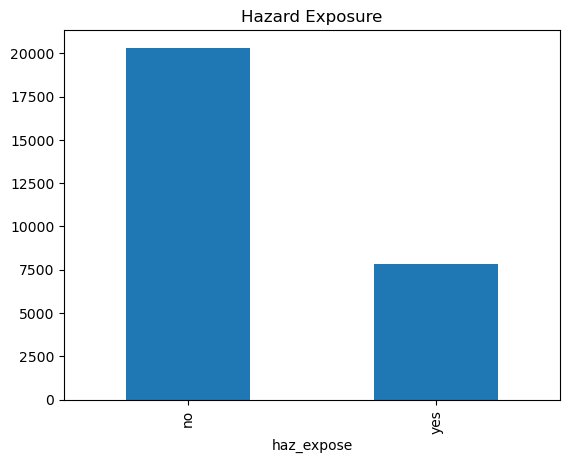

In [61]:
count = df_bldg_dmg_merged["haz_expose"].value_counts()
count.plot(kind="bar", title="Hazard Exposure")

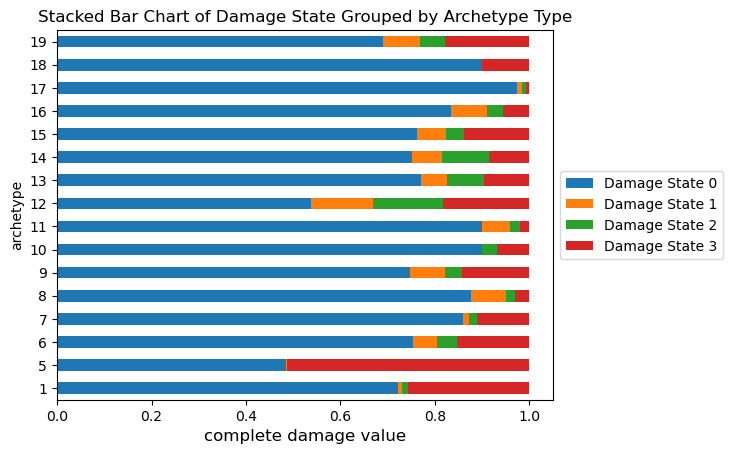

In [62]:
# Plot Damage state by archetype
ax = grouped_bldg_dmg[["Damage State 0", "Damage State 1", "Damage State 2", "Damage State 3"]].plot.barh(stacked=True)
ax.set_title("Stacked Bar Chart of Damage State Grouped by Archetype Type", fontsize=12)
ax.set_xlabel("complete damage value", fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) #here is the magic

## 2.3 Visualize results in map

## 2.4 Monte Carlo Simulation (MCS) to determine limit and damage state
MCS analysis uses damage output to calculate the probability of each building reaching specific damage states through a stochastic process. This example uses 500 iterations to estimate the failure probability for buildings reaching damage states 2, 3, and 4.

**More details can be found [Monte Carlo Limit State Probability Analysis](https://incore.ncsa.illinois.edu/doc/incore/analyses/mc_failure_prob.html)**

In [63]:
# Obtain the building damage results. The output of B
building_dmg_result = bldg_dmg.get_output_dataset('ds_result')

num_samples = 500 # Require 500 samples for convergence - Selected smaller samples for testing 
result_name = "Joplin_mc_failure_probability_buildings_dmg_result"

mc_bldg = MonteCarloFailureProbability(client)

mc_bldg.set_input_dataset("damage", building_dmg_result)
mc_bldg.set_parameter("num_cpu", 8)
mc_bldg.set_parameter("num_samples", num_samples)
mc_bldg.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3"])
mc_bldg.set_parameter("failure_state_keys", ["DS_2", "DS_3"])
mc_bldg.set_parameter("result_name", result_name) 

mc_bldg.run_analysis() 

True

### Building Sample Damage States

In [64]:
# Obtain buildings sample damage states
sample_damage_states = mc_bldg.get_output_dataset('sample_damage_states')  
df_bldg_ds = sample_damage_states.get_dataframe_from_csv()
df_bldg_ds.head()

,guid,sample_damage_states
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,"DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,D..."
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,"DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,D..."
2,758fb3de-108a-4e04-895e-fdc4b8627876,"DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,D..."
3,7b706697-bf9b-4883-90f6-862d67a8e64b,"DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,D..."
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,"DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,D..."


# 3. Electric Power Facility (EPF) Damage Analysis

The Joplin power network includes both electric power substations and power poles. Pyincore EPF damage analysis is applied to calculate the damage to this infrastructure using a similar approach to building damage. The following steps are used for the analysis:

- Import Electric Power Substation Data
- Specify Electric Power Substation Fragility and Mapping
- Setup and Run Electric Power Substation Damage Analysis
- Plot Results for Electric Power Substation Damage
- Monte Carlo Simulation (MCS) for Electric Power Substation
- Import Electric Power Pole Data
- Specify Electric Power Pole Fragility and Mapping
- Setup and Run Electric Power Pole Damage Analysis
- Plot Results for Electric Power Pole Damage
- Monte Carlo Simulation (MCS) for Electric Power Pole

**Details can be found here: [Electric Power Facility Damage](https://incore.ncsa.illinois.edu/doc/incore/analyses/epf_dmg.html)**

## 3.1 Substation Damage

In [65]:
epf_ss = Dataset.from_data_service("5d92355bb9219c06ae7e386a", data_services)

# Fragility mapping
mapping_id = "5d8a326fb9219c068ea798e7"

# Run epf damage 
epf_ss_dmg = EpfDamage(client)
epf_ss_dmg.set_input_dataset("epfs", epf_ss)

# Load fragility mapping
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
epf_ss_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [66]:
result_name = "Joplin_epf_substations_dmg_result"
epf_ss_dmg.set_parameter("result_name", result_name)
epf_ss_dmg.set_parameter("hazard_type", hazard_type)
epf_ss_dmg.set_parameter("hazard_id", hazard_id)
epf_ss_dmg.set_parameter("num_cpu", 4)
epf_ss_dmg.set_parameter("fragility_key", "substations")  # Define the result name, etc., and choose the number
                                                        # of CPU locally to run the model parallelly.

# Run Analysis
epf_ss_dmg.run_analysis()

True

In [67]:
epf_ss_dmg_df=epf_ss_dmg.get_output_dataset('result').get_dataframe_from_csv()
epf_ss_dmg_df.head()

,guid,LS_0,LS_1,LS_2,LS_3,DS_0,DS_1,DS_2,DS_3,DS_4,haz_expose
0,7f426763-81c6-4cac-b98d-c37a5e439b90,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
1,fc8add00-6760-4752-b1fb-7d6ca813f535,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
2,e8f4939d-763f-4743-bc61-c23e0b8e0f7a,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
3,2cab48ff-c5ce-495e-9662-67c9a177efc4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
4,eb4ce929-5164-4ebf-ace2-708096d89db5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no


### Visualize Electric Power Substation Damage

Text(0, 0.5, 'Counts')

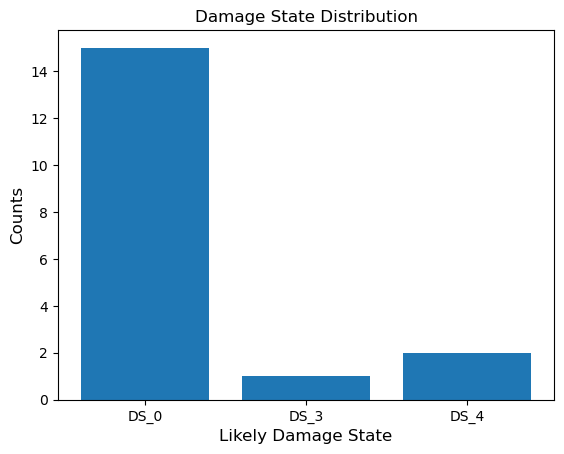

In [68]:
# Define the damage states
DS_list = np.array(['DS_0', 'DS_1', 'DS_2', 'DS_3', 'DS_4'])

# Determine the most likely damage state for each entry
spf_ss_likely_DS = DS_list[epf_ss_dmg_df[['DS_0', 'DS_1', 'DS_2', 'DS_3', 'DS_4']].values.argmax(axis=1)]

# Add the likely damage state to the dataframe
epf_ss_dmg_df['likelyDS'] = spf_ss_likely_DS

# Get the unique keys and their counts
keys, counts = np.unique(spf_ss_likely_DS, return_counts=True)

# Plot the damage state distribution
fig, ax = plt.subplots()
ax.bar(keys, counts)
ax.set_title("Damage State Distribution", fontsize=12)
ax.set_xlabel("Likely Damage State", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)

## 3.2 Monte Carlo Simulation (MCS) of Electric Power Substation

In [69]:
num_samples = 500
mc_sub = MonteCarloFailureProbability(client)

result_name = "Joplin_EPN_substations_mc_failure_probability"
substation_dmg_result=epf_ss_dmg.get_output_dataset('result')

mc_sub.set_input_dataset("damage", substation_dmg_result)
mc_sub.set_parameter("num_cpu", 8)
mc_sub.set_parameter("num_samples", num_samples)
mc_sub.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3", "DS_4"])
mc_sub.set_parameter("failure_state_keys", ["DS_2", "DS_3", "DS_4"])

mc_sub.set_parameter("result_name", result_name) # name of csv file with results
mc_sub.run_analysis()

True

In [70]:
substation_damage_mcs_samples = mc_sub.get_output_dataset('sample_failure_state')
sdmcs = substation_damage_mcs_samples.get_dataframe_from_csv()
sdmcs.head()

,guid,failure
0,7f426763-81c6-4cac-b98d-c37a5e439b90,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
1,fc8add00-6760-4752-b1fb-7d6ca813f535,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
2,e8f4939d-763f-4743-bc61-c23e0b8e0f7a,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
3,2cab48ff-c5ce-495e-9662-67c9a177efc4,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
4,eb4ce929-5164-4ebf-ace2-708096d89db5,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."


# 4. Physical Functionality Analysis
The MC samples from earlier subsection are used in this subsection to perform functionality analysis and determine the functionality state of each building. According to Almufti and Willford (2013), functionality is defined as the capacity of a component to serve its intended objectives consist of structural integrity, safety, and utilities (e.g., water and electricity). An individual building can be narrowly classified into five discrete states consist of the restricted entry (State 1), restricted use (State 2), preoccupancy (State 3), baseline functionality (State 4) and full functionality (State 5). In a broader classification, functionality states can be categorized into nonfunctional (States 1 to 3) and functional (States 4 and 5). This notebook relies on the latter broader classification approach to estimate the functionality state of each building and subsequently use functionality estimates to perfom functionality analysis by accounting for interdependency between buildings and lifeline networks (i.e., EPN) 

**Details can be found [Buidling Functionality Analysis](https://incore.ncsa.illinois.edu/doc/incore/analyses/building_func.html)**

In [71]:
depend_dict_id = "5dcf4a34b9219ca5e4118312"

bldg_func = BuildingFunctionality(client)

# Load the datasets of MC simulations for buildings
building_damage_mcs_samples = mc_bldg.get_output_dataset('sample_failure_state')  
bldg_func.set_input_dataset("building_damage_mcs_samples", building_damage_mcs_samples)
bldg_func.set_input_dataset("substations_damage_mcs_samples", substation_damage_mcs_samples)
bldg_func.load_remote_input_dataset("interdependency_dictionary", depend_dict_id)

result_name = "Joplin_mcs_functionality_probability"
bldg_func.set_parameter("result_name", result_name)

### Run the BuildingFunctionality module to obtain the building functionality probabilities
bldg_func.run_analysis() 

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [72]:
building_failure_probability=bldg_func.get_output_dataset('functionality_probability')
df_bldg_func = building_failure_probability.get_dataframe_from_csv()
df_bldg_func.head()

,guid,probability
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,1.0
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,1.0
2,758fb3de-108a-4e04-895e-fdc4b8627876,1.0
3,7b706697-bf9b-4883-90f6-862d67a8e64b,1.0
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,1.0


### Visualize Building Functionality

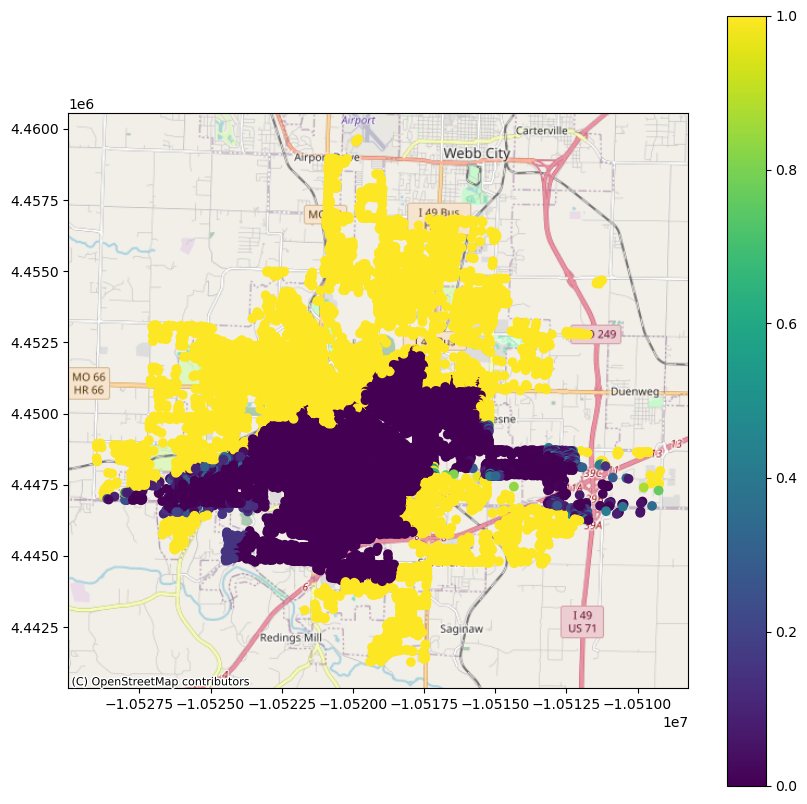

In [73]:
bldg_func_gdf = bldg_gdf.merge(df_bldg_func, on='guid')
viz.plot_gdf_map(bldg_func_gdf, column='probability')

# 5. Economic analysis

## 5.1. Capital stock shock analysis

This analysis aggregates building functionality states and calculates total capital shock losses per sector.

Capital stock shocks for an individual building is equal to the functionality probability multiplied by value of the building. This gives the capital stock loss in the immediate aftermath of a natural disaster. The analysis aggregates each of these individual losses to their associated economic sector and calculates the total capital stock lost for that particular sector.

**More details can be found [Capital Shock](https://incore.ncsa.illinois.edu/doc/incore/analyses/capital_shocks.html)**

In [74]:
# Joplin building to sector mapping table
building_to_sectors_id = "5f202d674620b643d787a5e7"
# Create Capital shocks analysis
capital_shocks = CapitalShocks(client)

# Load remote datasets
capital_shocks.load_remote_input_dataset("buildings_to_sectors", building_to_sectors_id)
# Set datasets
# Joplin building inventory
capital_shocks.load_remote_input_dataset("buildings", building_dataset_id)
# Joplin building failure probability
building_failure_probability = mc_bldg.get_output_dataset('failure_probability')  # get buildings failure probabilities
capital_shocks.set_input_dataset("failure_probability", building_failure_probability)

capital_shocks.set_parameter("result_name", "sector_shocks") # name of csv file with results

# Run capital shocks analysis
capital_shocks.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [75]:
sector_shocks_result = capital_shocks.get_output_dataset("sector_shocks")
sector_shocks_result.get_dataframe_from_csv()

,sector,shock
0,HS1,0.664893
1,HS2,0.640524
2,GOODS,0.861727
3,OTHER,0.849257
4,TRADE,0.856724
5,HS,0.974672
6,HS3,0.534856


## 5.2 Create Joplin CGE Model

A computable general equilibrium (CGE) model is based on fundamental economic principles. A CGE model uses multiple data sources to model the interactions of households, firms and relevant government entities as they contribute to economic activity. The model is based on (1) utility-maximizing households that supply labor and capital, using the proceeds to pay for goods and services (both locally produced and imported) and taxes; (2) the production sector, with perfectly competitive, profit-maximizing firms using intermediate inputs, capital, land and labor to produce goods and services for both domestic consumption and export; (3) the government sector that collects taxes and uses tax revenues in order to finance the provision of public services; and (4) the rest of the world.

**More details can be found [Joplin Computable General Equilibrium (CGE)](https://incore.ncsa.illinois.edu/doc/incore/analyses/joplin_cge.html)**

In [76]:
joplin_cge = JoplinCGEModel(client)

# SAM
# Social accounting matrix (SAM) contains data for firms, households and government which are organized 
# in a way to represent the interactions of all three entities in a typical economy
SAM = "5dd85ae7b9219c06d4da8de4"

# CAPITAL COMP
# BB is a matrix which describes how investment in physical infrastructure is transformed into functioning capital such as commercial and residential buildings. 
# These data are collected from the Bureau of Economic Analysis (BEA).
BB = "5dc1e620b9219c06dd2f473a"

# MISC TABLES
IOUT = "5dc1e6d8b9219c06dd2f475e"  # This is matrix that describes the transfer of tax revenue collected by the local government to help finance local government expenditures. 
MISC = "5dc1e736b9219c06dd2f4782"  # This is the name of a file that contains data for commercial sector employment and physical capital. It also contains data for the number of households and working households in the economy. 
MISCH = "5dc1e7b5b9219c06dd2f47a6"  # A file that contains elasticities for the supply of labor with respect to paying income taxes.
LANDCAP = "5dc1e810b9219c06dd2f47ca"  # Contains information regarding elasticity values for the response of changes in the price of physical capital with respect to the supply of investment.
EMPLOY = "5dc1e85ab9219c06dd2f47ee"  # Table name containing data for commercial sector employment.
IGTD = "5dc1e895b9219c06dd2f4812"  # This variable represents a matrix describing the transfer of taxes collected to a variable which permits governments to spend the tax revenue on workers and intermediate inputs.
TAUFF = "5dc1e8eeb9219c06dd2f4836"  # Represents social security tax rates
JOBCR = "5dc1e962b9219c06dd2f487e"  # This is a matrix describing the supply of workers coming from each household group in the economy. 
OUTCR = "5dc1e9aeb9219c06dd2f48bc"  # This a matrix describing the number of workers who live in Joplin but commute outside of town to work.

# Set analysis input datasets
joplin_cge.load_remote_input_dataset("SAM", SAM)
joplin_cge.load_remote_input_dataset("BB", BB)
joplin_cge.load_remote_input_dataset("IOUT", IOUT)
joplin_cge.load_remote_input_dataset("MISC", MISC)
joplin_cge.load_remote_input_dataset("MISCH", MISCH)
joplin_cge.load_remote_input_dataset("LANDCAP", LANDCAP)
joplin_cge.load_remote_input_dataset("EMPLOY", EMPLOY)
joplin_cge.load_remote_input_dataset("IGTD", IGTD)
joplin_cge.load_remote_input_dataset("TAUFF", TAUFF)
joplin_cge.load_remote_input_dataset("JOBCR", JOBCR)
joplin_cge.load_remote_input_dataset("OUTCR", OUTCR)
joplin_cge.set_input_dataset("sector_shocks", sector_shocks_result)

# Set analysis parameters
joplin_cge.set_parameter("solver_path", "ipopt")
joplin_cge.set_parameter("model_iterations", 1)

# Run CGE
joplin_cge.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset 

True

In [77]:
domestic_supply = joplin_cge.get_output_dataset('domestic-supply')
ds = domestic_supply.get_dataframe_from_csv()
# Display top 6 rows of output data
ds.head(6)

,Sectors,DS0,DSL
0,Goods,682.797727,648.324363
1,Trades,229.636282,167.939027
2,Others,266.695641,187.467499
3,HS1,22.018314,13.216032
4,HS2,1361.165027,1260.694238
5,HS3,477.922693,438.707455


In [78]:
pre_factor_demand = joplin_cge.get_output_dataset('pre-disaster-factor-demand')
pre_fd = pre_factor_demand.get_dataframe_from_csv()
pre_fd.head()

,Labor Group,GOODS,TRADE,OTHER
0,L1,449.006038,2729.055379,6306.146353
1,L2,3282.049564,4360.095686,12396.308192
2,L3,3013.051661,1851.044407,5444.146479


In [79]:
post_factor_demand = joplin_cge.get_output_dataset('post-disaster-factor-demand')
pos_fd = post_factor_demand.get_dataframe_from_csv()
pos_fd.head()

,Labor Group,GOODS,TRADE,OTHER
0,L1,435.410408,2532.125807,5916.088572
1,L2,3163.412772,4020.990571,11559.181688
2,L3,2882.871337,1694.579022,5039.326305


In [80]:
household_count = joplin_cge.get_output_dataset('household-count')
hc = household_count.get_dataframe_from_csv()
hc.head()

,Household Group,HH0,HHL
0,HH1,3611.010342,3581.301855
1,HH2,5997.031159,5908.895851
2,HH3,7544.090149,7255.775194
3,HH4,2394.098104,2133.387507
4,HH5,793.009003,753.989958


### Visualize the economic impact of the damage

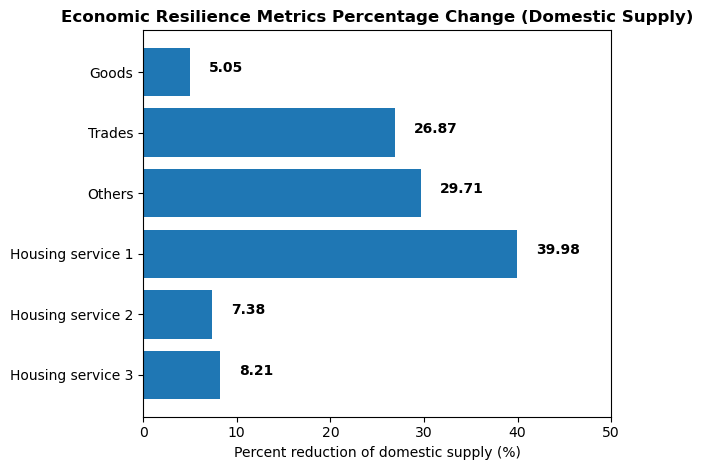

In [81]:
plt.rcdefaults()
fig_ds, ax_ds = plt.subplots()

sectors_ds = ('Goods', 'Trades', 'Others', 'Housing service 1', 'Housing service 2', 'Housing service 3')
y_pos_ds = np.arange(len(sectors_ds))
perf_ds = (1 - ds['DSL'] / ds['DS0']) * 100  # percentage

for i, v in enumerate(round(perf_ds, 2)):
    ax_ds.text(v + 2, i, str(v), color='black', fontweight='bold')
ax_ds.barh(y_pos_ds, perf_ds, align='center', height=0.8)
ax_ds.set_yticks(y_pos_ds)
ax_ds.set_yticklabels(sectors_ds)
ax_ds.invert_yaxis()
ax_ds.set_title('Economic Resilience Metrics Percentage Change (Domestic Supply)', fontsize=12, weight='bold')
ax_ds.set_xlabel('Percent reduction of domestic supply (%)')
plt.xlim(0, 50)
fig_ds.tight_layout()
plt.show()

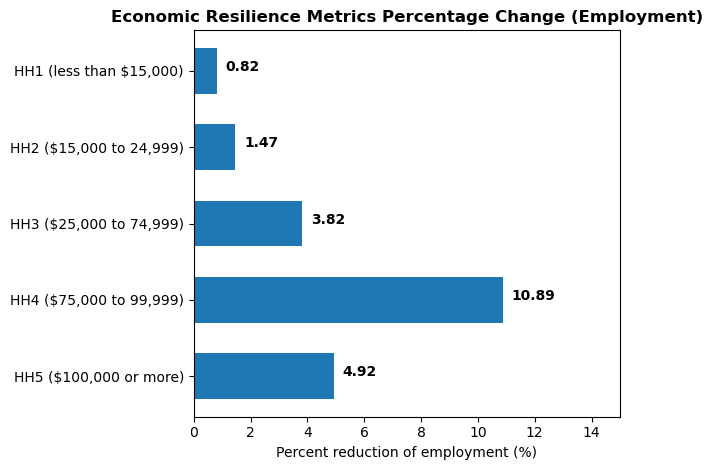

In [82]:
plt.rcdefaults()
fig_hc, ax_hc = plt.subplots()
household_hc = ('HH1 (less than $15,000)', 'HH2 ($15,000 to 24,999)', 'HH3 ($25,000 to 74,999)',
                'HH4 ($75,000 to 99,999)', 'HH5 ($100,000 or more)')
y_pos = np.arange(len(household_hc))
perf_hc = (1 - hc['HHL'] / hc['HH0']) * 100  # percentage

for i, v in enumerate(round(perf_hc, 2)):
    ax_hc.text(v + 0.3, i, str(v), color='black', fontweight='bold')
ax_hc.barh(y_pos, perf_hc, align='center', height=0.6)
ax_hc.set_yticks(y_pos)
ax_hc.set_yticklabels(household_hc)
ax_hc.invert_yaxis()
ax_hc.set_title('Economic Resilience Metrics Percentage Change (Employment)', fontsize=12, weight='bold')
ax_hc.set_xlabel('Percent reduction of employment (%)')
plt.xlim(0, 15)
fig_hc.tight_layout()
plt.show()

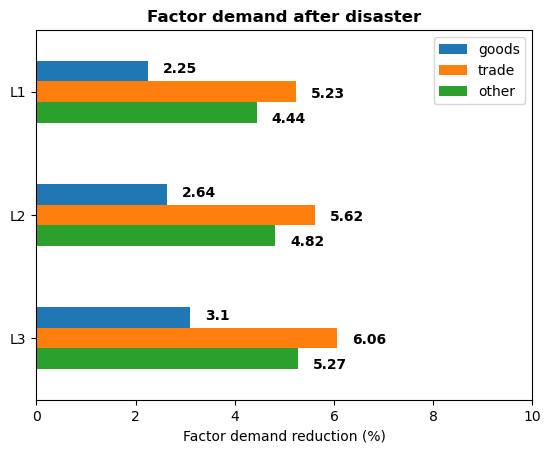

In [83]:
# Labor groups
data_pre = {"Sectors": ["L1", "L2", "L3"],
            "GOODS": [449.006038, 3282.049564, 3013.051661],
            "TRADE": [2729.055379, 4360.095686, 1851.044407],
            "OTHER": [6306.146353, 12396.308192, 5444.146479]}
pre_fd = pd.DataFrame(data_pre)
data_pos = {"Sectors": ["L1", "L2", "L3"],
            "GOODS": [438.913649, 3195.254485, 2919.538642],
            "TRADE": [2586.192593, 4115.076833, 1738.785852],
            "OTHER": [6026.389334, 11798.285962, 5157.077844]}
pos_fd = pd.DataFrame(data_pos)

perf_gd = (1 - pos_fd['GOODS'] / pre_fd['GOODS']) * 100  # percentage
perf_tr = (1 - pos_fd['TRADE'] / pre_fd['TRADE']) * 100
perf_ot = (1 - pos_fd['OTHER'] / pre_fd['OTHER']) * 100

# Labor groups
labor_groups = ('L1', 'L2', 'L3')
goods = perf_gd.values.round(2).tolist()
trade = perf_tr.values.round(2).tolist()
other = perf_ot.values.round(2).tolist()

y_pos_fd = np.arange(len(labor_groups))

plt.rcdefaults()
df_all = pd.DataFrame({'goods': goods, 'trade': trade, 'other': other}, index = labor_groups)
ax_fd = df_all.plot.barh(align='center')

for i, v in enumerate(round(perf_gd, 2)):
    ax_fd.text(v + 0.3, i - 0.15, str(v), color='black', fontweight='bold')
for i, v in enumerate(round(perf_tr, 2)):
    ax_fd.text(v + 0.3, i + 0.05, str(v), color='black', fontweight='bold')
for i, v in enumerate(round(perf_ot, 2)):
    ax_fd.text(v + 0.3, i + 0.25, str(v), color='black', fontweight='bold')
ax_fd.set_yticks(y_pos_fd)
ax_fd.set_yticklabels(labor_groups)
ax_fd.invert_yaxis()
ax_fd.set_xlabel('Factor demand reduction (%)')
ax_fd.set_title('Factor demand after disaster', fontsize=12, weight='bold')
plt.xlim(0, 10)
plt.show()

# 6. Sociological Analysis
This section introduces the sociology-based analysis which may be integrated with hazard and building damage analysis. In this example the damage to buildings drives the population dislocation algorithm at the household level. 

## 6.1 Popoulation Dislocation
The population dislocation model predicts which households within the community will be dislocated from their homes immediately following the hazard event. It depends first on the allocation of detailed housing unit and household characteristic data to each residential building within the community. The allocation of detailed household characteristic data provides an estimate of the number of people that live within each structure. The dislocation model is based on household surveys, for a more detailed summary of the dislocation model please refer to Rosenheim, Guidotti, Gardoni, and Peacock 2019.

**More details about the analysis: [Population Dislocation](https://incore.ncsa.illinois.edu/doc/incore/analyses/populationdislocation.html)**

In [84]:
bg_data = "5d4c9545b9219c0689b2358a"
housing_unit_alloc = "5dc1c196b9219c06dd2e3f0b"
value_loss = "60354810e379f22e16560dbd"

# Create Population dislocation analysis
pop_dis = PopulationDislocation(client)
# Load analysis input datasets
pop_dis.load_remote_input_dataset("housing_unit_allocation", housing_unit_alloc)
pop_dis.load_remote_input_dataset("block_group_data", bg_data)
pop_dis.load_remote_input_dataset("value_loss_param", value_loss)
building_dmg_result = bldg_dmg.get_output_dataset('ds_result')
pop_dis.set_input_dataset("building_dmg", building_dmg_result)

result_name = "pop-dislocation-results"
seed = 1111

pop_dis.set_parameter("result_name", result_name)
pop_dis.set_parameter("seed", seed)
pop_dis.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [85]:
# Retrieve result dataset
pop_result = pop_dis.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
pop_df = pop_result.get_dataframe_from_csv(low_memory=False)
pop_df.head()

,guid,DS_0,DS_1,DS_2,DS_3,haz_expose,strctid,statefp10,tractce10,pumgeoid10,...,phispbg,d_sf,rploss_0,rploss_1,rploss_2,rploss_3,prdis,dislocated,choice_dis,unsafe_occ
0,59fc3532-2c7d-4d68-b7d5-5a7b6ed4a556,1.0,0.0,0.0,0.0,no,S0021177,29.0,10100.0,2902800.0,...,3.075489,1,0.002914,0.100425,0.524702,0.889881,0.0,False,NaN,NaN
1,535a461c-f028-4e05-9100-43541b645f1c,1.0,0.0,0.0,0.0,no,S0023095,29.0,10100.0,2902800.0,...,3.075489,1,0.006930,0.132025,0.677548,0.951019,0.0,False,NaN,NaN
2,38688790-543b-4a28-9530-49975d353de4,1.0,0.0,0.0,0.0,no,S0021178,29.0,10100.0,2902800.0,...,3.075489,1,0.005776,0.100000,0.654935,0.941974,0.0,False,NaN,NaN
3,e791aea5-706d-4e59-b4e9-0eada663b6c7,1.0,0.0,0.0,0.0,no,S0023093,29.0,10100.0,2902800.0,...,3.075489,1,0.002404,0.105851,0.436479,0.854591,0.0,False,NaN,NaN
4,46b98fd2-f0d0-4ef4-9de3-ea1798e93050,1.0,0.0,0.0,0.0,no,S0023044,29.0,10100.0,2902800.0,...,3.075489,1,0.003029,0.133077,0.438777,0.855511,0.0,False,NaN,NaN


### Interpret the dislocation result
The variable ownershp represents the tenure status of households. When ownershp = 1 the housing unit is owner-occupied. When the ownershp = 2 the housing unit is renter-occupied. The results above provide the percent of the population predicted to dislocate based on tenure status. When the variable `dislocated = True` the household is predicted to dislocate.

In [87]:
table_title = "Total population by tenure status and dislocation."
pd.crosstab(pop_df['ownershp'], pop_df['dislocated'], pop_df['numprec'], aggfunc = sum,
            dropna=True, margins=True, margins_name="Total").style.set_caption(table_title)

dislocated,False,True,Total
ownershp,,,
1.000000,110208.000000,7251.000000,117459.000000
2.000000,47879.000000,5888.000000,53767.000000
Total,158087.000000,13139.000000,171226.000000


## 6.2 Social Vunerability

This analysis computes a social vulnerability score for per associated zone in census data. The computation extracts zoning and a social vulnerability score obtained by computing demographic features of interest against national average values.
> Refer to Enderami, S. A., and Sutley, E. (2024). Social vulnerability score: a scalable index for representing social vulnerability in virtual community resilience testbeds. Natural Hazards. https://doi.org/10.1007/s11069-024-06499-z.

**More details: [Social Vunerability Score Analysis](https://incore.ncsa.illinois.edu/doc/incore/analyses/social_vulnerability.html)**

In [88]:
# Configure pyincore access and the analysis with the information above
social_vulnerability = SocialVulnerability(client)

social_vulnerability.set_parameter("result_name", "social_vulnerabilty")
social_vulnerability.load_remote_input_dataset("national_vulnerability_feature_averages", "63d178c2a011a9746c948115")
social_vulnerability.load_remote_input_dataset("social_vulnerability_demographic_factors", "63d17d89c4b5713b9c0bb8c1")

# Run social vulnerability damage analysis
social_vulnerability.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


In [89]:
# Retrieve result dataset
sv_result = social_vulnerability.get_output_dataset("sv_result")
sv_result_df = sv_result.get_dataframe_from_csv(low_memory=False)
sv_result_df.head()

,GEO_ID,factor_white_nonHispanic,factor_owner_occupied,factor_earning_higher_than_national_poverty_rate,factor_over_25_with_high_school_diploma_or_higher,factor_without_disability_age_18_to_65,FIPS,R1,R2,R3,R4,R5,SVS,zone
0,1500000US290970101001,0.801980,0.113095,0.676471,0.825769,0.437086,290970101001,1.347610,0.175512,0.778883,0.933975,0.794373,0.806071,Medium to High Vulnerable (zone4)
1,1500000US290970101002,0.740566,0.299191,0.586085,0.922481,0.487719,290970101002,1.244413,0.464314,0.674814,1.043360,0.886395,0.862659,Medium to High Vulnerable (zone4)
2,1500000US290970101003,0.809578,0.645233,0.912201,0.851740,0.089588,290970101003,1.360377,1.001333,1.050301,0.963349,0.162820,0.907636,Medium to High Vulnerable (zone4)
3,1500000US290970101004,0.629681,0.564417,0.680999,0.881497,0.480000,290970101004,1.058087,0.875916,0.784097,0.997006,0.872366,0.917494,Medium to High Vulnerable (zone4)
4,1500000US290970102001,0.772790,0.775882,0.929544,0.980226,0.089118,290970102001,1.298561,1.204087,1.070271,1.108672,0.161966,0.968711,Medium Vulnerable (zone3)


## 6.3 Household Level Housing Recovery Analysis

This analysis computes the series of household recovery states given a population dislocation dataset, a transition probability matrix (TPM) and an initial state vector.

The computation operates by segregating household units into five zones as a way of assigning social vulnerability. Using this vulnerability in conjunction with the TPM and the initial state vector, a Markov chain computation simulates most probable states to generate a stage history of housing recovery changes for each household.

> Sutley, E.J. and Hamideh, S., 2020. Postdisaster housing stages: a Markov chain approach to model sequences and duration based on social vulnerability. Risk Analysis, 40(12), pp.2675-2695.

**More details: [Household Level Housing Recovery Analysis](https://incore.ncsa.illinois.edu/doc/incore/analyses/housing_household_recovery.html)**

In [90]:
housing_data = Dataset.from_data_service(housing_unit_alloc, data_services)
housing_inv = housing_data.get_dataframe_from_csv(low_memory=False)

# Population dislocation result aggregated to the block group level.
# Transition probability matrix per social vulnerability level.
transition_probability_matrix = "60f5e2ae544e944c3cec0794"
# Initial mass probability function for stage 0.
initial_probability_vector = "60f5e918544e944c3cec668b"

# Create housing recovery instance
housing_recovery = HousingRecoverySequential(client)

# Load input datasets
housing_recovery.set_input_dataset("population_dislocation_block", pop_result)
housing_recovery.load_remote_input_dataset("tpm", transition_probability_matrix)
housing_recovery.load_remote_input_dataset("initial_stage_probabilities", initial_probability_vector)
housing_recovery.set_parameter("num_cpu", 4)

# Chain with SV output
housing_recovery.set_input_dataset('sv_result', sv_result)

# Initial value to seed the random number generator to ensure replication
seed = 1111
# A size of the analysis time step.
t_delta = 1.0
# Total duration.
t_final = 90.0


# Specify the result name
result_name = "housing_recovery_result"

# Set analysis parameters
housing_recovery.set_parameter("result_name", result_name)
housing_recovery.set_parameter("seed", seed)
housing_recovery.set_parameter("t_delta", t_delta)
housing_recovery.set_parameter("t_final", t_final)

housing_recovery.run()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [91]:
# Retrieve result dataset
result = housing_recovery.get_output_dataset("ds_result")

# Convert dataset to Pandas DataFrame
HH_stagehistory_DF = result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
HH_stagehistory_DF.head()

,guid,huid,Zone,SV,1,2,3,4,5,6,...,81,82,83,84,85,86,87,88,89,90
0,59fc3532-2c7d-4d68-b7d5-5a7b6ed4a556,B290970101001000H003,Z4,0.785,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
1,535a461c-f028-4e05-9100-43541b645f1c,B290970101001000H001,Z4,0.662,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
2,38688790-543b-4a28-9530-49975d353de4,B290970101001000H002,Z4,0.647,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,e791aea5-706d-4e59-b4e9-0eada663b6c7,B290970101001001H001,Z4,0.747,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
4,46b98fd2-f0d0-4ef4-9de3-ea1798e93050,B290970101001002H002,Z4,0.757,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


## Visualize the series of household recovery states 
- ES: Emergency Shelter
- TS: Temporary Shelter
- TH: Temporary Housing
- PH: Permanent Housing
- F: Failure

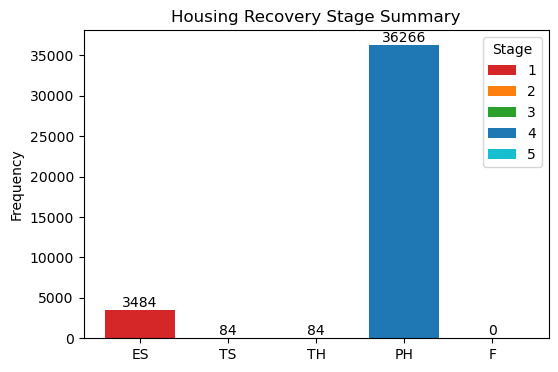

In [92]:
Stage = HH_stagehistory_DF["1"]

plt.rcParams["figure.figsize"] = [6, 4]

fig, ax = plt.subplots()
h_states = ['ES', 'TS', 'TH', 'PH', 'F']

counts = [(Stage==1.0).sum(),(Stage==2.0).sum(),(Stage==3.0).sum(),(Stage==4.0).sum(),(Stage==5.0).sum()]
bar_labels = ['1', '2', '3', '4','5']
bar_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:cyan']

ax.bar(h_states, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Frequency')
ax.set_title('Housing Recovery Stage Summary')
ax.legend(title='Stage')

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

# 7. Retrofit Strategies

Building retrofit involves enhancing the structural integrity of existing buildings to withstand natural hazards. The retrofit plan is generated as an optimal solution given budget and other constraints. Here is a list of retrofit strategies for Joplin:

| Construction Product Combination      | Roof Covering     | Roof Covering     | Roof Covering | Roof Sheathing Nailing Pattern | Roof Sheathing Nailing Pattern | Roof-to-Wall Connection Type | Roof-to-Wall Connection Type | Roof-to-Wall Connection Type |
|---------------------------------------|-------------------|-------------------|---------------|-------------------------------|-------------------------------|-----------------------------|-----------------------------|-----------------------------|
|                                       | Wood Shingles     | Asphalt Shingles  | Clay Tiles    | 8d C6/12                      | 8d C6/6                       | Two 16d Toe Nails           | H2.5 Clip                   | Two H2.5 Clips              |
| Original Construct Product Combination | X                 | -                 | -             | X                             | -                             | X                           | -                           | -                           |
| Retrofit Strategy A                   | -                 | X                 | -             | X                             | -                             | X                           | -                           | -                           |
| Retrofit Strategy B                   | -                 | X                 | -             | -                             | X                             | -                           | -                           | X                           |
| Retrofit Strategy C                   | -                 | -                 | X             | -                             | X                             | -                           | -                           | X                           |

To apply different retrofit strategies to building damage analyses, we can simply use the same `BuildingDamage` object and run analyses with different `retrofit_strategy` parameters.

In [93]:
# Retrofit Strategy A: 
retrofit_strategy_A_id = "6614a2851f87410ae38a69f1" # 100% Retrofit Method 1
retrofit_strategy_plan = Dataset.from_data_service(retrofit_strategy_A_id, data_services)
bldg_dmg.set_input_dataset("retrofit_strategy", retrofit_strategy_plan)
bldg_dmg.run_analysis()
bldg_dmg_df_A=bldg_dmg.get_output_dataset('ds_result').get_dataframe_from_csv()

# Retrofit Strategy B: 
retrofit_strategy_B_id = "6614a2b3099327393f84baa5" # 100% Retrofit Method 2
retrofit_strategy_plan = Dataset.from_data_service(retrofit_strategy_B_id, data_services)
bldg_dmg.set_input_dataset("retrofit_strategy", retrofit_strategy_plan)
bldg_dmg.run_analysis()
bldg_dmg_df_B=bldg_dmg.get_output_dataset('ds_result').get_dataframe_from_csv()

# Retrofit Strategy C: 
retrofit_strategy_C_id = "6614a2e21f87410ae38a6aa2" # 100% Retrofit Method 3
retrofit_strategy_plan = Dataset.from_data_service(retrofit_strategy_C_id, data_services)
bldg_dmg.set_input_dataset("retrofit_strategy", retrofit_strategy_plan)
bldg_dmg.run_analysis()
bldg_dmg_df_C=bldg_dmg.get_output_dataset('ds_result').get_dataframe_from_csv()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


## Visualize damage state distribution between different retrofit strategies

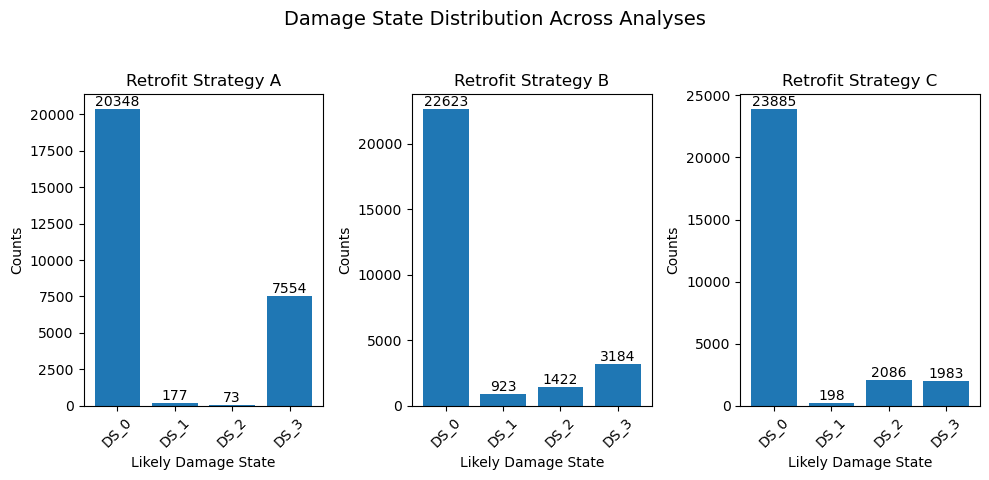

In [96]:
# Create a single figure and a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5)) # Adjust the figure size as needed
fig.suptitle('Damage State Distribution Across Analyses', fontsize=14)

# Flatten the axs array for easy iteration
axs = axs.flatten()

# List of DataFrames for iteration
df_list = [bldg_dmg_df_A, bldg_dmg_df_B, bldg_dmg_df_C]
# Titles for each subplot
titles = ['Retrofit Strategy A', 'Retrofit Strategy B', 'Retrofit Strategy C'] 

# Loop through the DataFrames and their corresponding axes and titles
for ax, df, title in zip(axs, df_list, titles):
    # Perform your analysis here
    DSlist = np.array(['DS_0', 'DS_1', 'DS_2', 'DS_3'])
    spf_ss_likelyDS = DSlist[df.loc[:,['DS_0', 'DS_1', 'DS_2', 'DS_3']].values.argmax(axis=1)]
    df['likelyDS'] = spf_ss_likelyDS
    keys, counts = np.unique(spf_ss_likelyDS, return_counts=True)
    
    # Plot on the current axis
    ax.bar(keys, counts)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Likely Damage State", fontsize=10)
    ax.set_ylabel("Counts", fontsize=10)
    ax.tick_params(axis='x', rotation=45) # Optional: Rotate x-axis labels for better readability
    
    # Ensure correct value annotations on each bar
    for bars in ax.containers:
        ax.bar_label(bars)

# Adjust layout for better spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()